# Adversarial training for machine learning models

## Background

With the prevalence of machine learning models, it is becoming increasingly important to ensure that they are not vulnerable to adversarial attacks. We will study methods to create and defend against such attacks on machine learning models.

## Basic model
We will begin by training a traditional CNN on the CIFAR-10 dataset.

In [1]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models import resnet18
from torchvision import transforms as T
import matplotlib.pyplot as plt

In [9]:
# Load datasets
cifar_10_train = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=T.ToTensor(), download=True)
cifar_10_test = torchvision.datasets.CIFAR10("CIFAR10", train=False, transform=T.ToTensor(), download=True)

batch_size = 64
train_loader = DataLoader(cifar_10_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(cifar_10_test, batch_size=batch_size, shuffle=False)
sample_img, sample_lbl = next(iter(train_loader))
print(f"Image batch shape: {sample_img.size()}")
print(f"Label batch shape: {sample_lbl.size()}")

transform = T.Compose(
    [
        # Exact transforms used were suggested by ChatGPT
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]
)

cifar_10_train = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=transform)

batch_size = 64
train_loader_augmented = DataLoader(cifar_10_train, batch_size=batch_size, shuffle=True)

# Load CUDA and CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cpu_device = 'cpu'

Files already downloaded and verified
Files already downloaded and verified
Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


In [3]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn = nn.Sequential(
      # use 2 convolution layers and 4 linear layers
      nn.Conv2d(3, 16, 5),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(16, 64, 3),
      nn.MaxPool2d(2, stride=2),

      nn.Flatten(),

      nn.Linear(2304, 256),
      nn.ReLU(),

      nn.Linear(256, 256),
      nn.ReLU(),

      nn.Linear(256, 100),
      nn.ReLU(),

      nn.Linear(100, 10),
      nn.ReLU(),
    )

  def forward(self, x):
    return self.nn.forward(x)

In [4]:
def evaluate(model, data_loader):
    """Evaluate the model on the given dataset."""
    # Set the model to evaluation mode.
    model.eval()
    correct = 0
    # The `torch.no_grad()` context will turn off gradients for efficiency.
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            pred = output.argmax(dim=1)
            correct += (pred == labels).sum().item()
    return correct / len(data_loader.dataset)

def train(model, n_epoch, optimizer, scheduler, augment=False, attack_fn=None, eps=0.01):
    """Train the model on the given dataset."""
    loss_fn = nn.CrossEntropyLoss()

    loader = train_loader
    if augment:
      loader = train_loader_augmented

    for epoch in range(n_epoch):
        # Set the model to training mode.
        model.train()
        for step, (images, labels) in enumerate(loader):
            # 0. Prepare the data. Move the data to the device (CPU/GPU).
            images, labels = images.to(device), labels.to(device)
            # 1. Clear previous gradients.
            optimizer.zero_grad()

            # Train with defense against adversarial attacks
            # You can ignore this for now, it will be explained later in the notebook
            if attack_fn is not None:
                # Loss on the FGSM/PGD example
                model.eval()
                images = attack_fn(model, images, labels, eps, False)
                model.train()

            # 2. Forward pass. Calculate the output of the model.
            output = model(images)
            # 3. Calculate the loss.
            loss = loss_fn(output, labels)
            # 4. Calculate the gradients. PyTorch does this for us!
            loss.backward()
            # 5. Update the model parameters.
            optimizer.step()
            if step % 700 == 0:
                print(f"Epoch {epoch}, Step {step}, Loss {loss.item():.4f}")
        # 6. (Optional) Update the learning rate.
        scheduler.step()
        acc = evaluate(model, valid_loader)
        print(f"Epoch {epoch}, Valid Accuracy {acc * 100:.2f}%")

        acc = evaluate(model, train_loader)
        print(f"Epoch {epoch}, Train Accuracy {acc * 100:.2f}%")

In [ ]:
# setup and train the neural network
model_normal = CNN().to(device)

lr = 1e-3
gamma = 0.9
num_epoch = 10

optimizer = torch.optim.Adam(model_normal.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

train(model_normal, num_epoch, optimizer, scheduler)

Epoch 0, Step 0, Loss 2.3021
Epoch 0, Step 700, Loss 1.3658


100%|██████████| 157/157 [00:01<00:00, 92.65it/s]


Epoch 0, Valid Accuracy 52.08%


100%|██████████| 782/782 [00:08<00:00, 95.88it/s] 


Epoch 0, Train Accuracy 54.27%
Epoch 1, Step 0, Loss 1.3532
Epoch 1, Step 700, Loss 1.0717


100%|██████████| 157/157 [00:01<00:00, 107.63it/s]


Epoch 1, Valid Accuracy 58.19%


100%|██████████| 782/782 [00:07<00:00, 107.33it/s]


Epoch 1, Train Accuracy 62.83%
Epoch 2, Step 0, Loss 1.1432
Epoch 2, Step 700, Loss 1.1899


100%|██████████| 157/157 [00:01<00:00, 107.76it/s]


Epoch 2, Valid Accuracy 60.42%


100%|██████████| 782/782 [00:08<00:00, 93.53it/s] 


Epoch 2, Train Accuracy 67.86%
Epoch 3, Step 0, Loss 0.7600
Epoch 3, Step 700, Loss 1.0916


100%|██████████| 157/157 [00:01<00:00, 86.79it/s]


Epoch 3, Valid Accuracy 62.76%


100%|██████████| 782/782 [00:07<00:00, 98.52it/s] 


Epoch 3, Train Accuracy 72.92%
Epoch 4, Step 0, Loss 0.5645
Epoch 4, Step 700, Loss 0.7468


100%|██████████| 157/157 [00:01<00:00, 105.90it/s]


Epoch 4, Valid Accuracy 63.05%


100%|██████████| 782/782 [00:07<00:00, 105.15it/s]


Epoch 4, Train Accuracy 76.67%
Epoch 5, Step 0, Loss 0.8476
Epoch 5, Step 700, Loss 0.6173


100%|██████████| 157/157 [00:01<00:00, 105.46it/s]


Epoch 5, Valid Accuracy 63.06%


100%|██████████| 782/782 [00:08<00:00, 93.92it/s] 


Epoch 5, Train Accuracy 79.23%
Epoch 6, Step 0, Loss 0.6354
Epoch 6, Step 700, Loss 0.4523


100%|██████████| 157/157 [00:02<00:00, 75.26it/s]


Epoch 6, Valid Accuracy 62.94%


100%|██████████| 782/782 [00:07<00:00, 102.60it/s]


Epoch 6, Train Accuracy 82.31%
Epoch 7, Step 0, Loss 0.4217
Epoch 7, Step 700, Loss 0.4207


100%|██████████| 157/157 [00:01<00:00, 109.22it/s]


Epoch 7, Valid Accuracy 63.31%


100%|██████████| 782/782 [00:07<00:00, 100.97it/s]


Epoch 7, Train Accuracy 84.55%
Epoch 8, Step 0, Loss 0.4740
Epoch 8, Step 700, Loss 0.3455


100%|██████████| 157/157 [00:01<00:00, 109.08it/s]


Epoch 8, Valid Accuracy 62.91%


100%|██████████| 782/782 [00:08<00:00, 93.75it/s] 


Epoch 8, Train Accuracy 85.93%
Epoch 9, Step 0, Loss 0.3670
Epoch 9, Step 700, Loss 0.2598


100%|██████████| 157/157 [00:02<00:00, 77.18it/s]


Epoch 9, Valid Accuracy 62.36%


100%|██████████| 782/782 [00:07<00:00, 106.74it/s]

Epoch 9, Train Accuracy 86.42%


This model achieves 60% accuracy on the validation set and 90% accuracy on the training set. We will now attempt to attack the model using several different techniques.

## Methodology
We will apply a transformation to each image in the training set, and determine whether the transformed image has the same class as the original.

We begin with adding noise to the image (pixel modifications with a maxiumum $L_\infty$ norm of $\epsilon$) as our transformation.

The first technique to explore is called FGSM (Fast Gradient Sign Method) and works by taking one step in the direction of the positive gradient from the image (ie, moving in the direction of least confidence for the classifier).

In [5]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
# A targeted attack is one where we want the classifier to misclassify as a specific class.
# If the attack is untargeted, target should be set to the output class of the classifier.
def fgsm(model, x, target, eps, targeted=True):
    finalout = []
    L = nn.CrossEntropyLoss()

    x.requires_grad_()
    loss = L(model(x), target.clone().detach())
    loss.backward()

    # take the largest possible step in the direction of the gradient
    finalout = torch.sign(x.grad)

    if targeted:
        finalout *= -1

    return (x + (eps * finalout)).detach()

We now analyze the model's accuracy on a version of the training set perturbed by FGSM. We will use an untargeted attack to get the largest effect possible.

In [6]:
def evaluate_adversarial_attack(model_normal, attack_fn, eps):
  image_count = 0
  correct_count = 0

  model_normal.eval()
  model_normal = model_normal.to(device)

  for step, (images, labels) in enumerate(train_loader):
      # 0. Prepare the data. Move the data to the device (CPU/GPU).
      images, labels = images.to(device), labels.to(device)
      # 1. Clear previous gradients.
      optimizer.zero_grad()
      # Take a step away from the correct label rather than away from the predicted label.
      perturbed_input = attack_fn(model_normal, images, labels, eps, False)

      output = model_normal(perturbed_input)
      pred = output.argmax(dim=1)
      correct_count += (pred == labels).sum().item()
      image_count += len(perturbed_input)

  print("Adversarial robustness: ", correct_count / image_count)

In [ ]:
evaluate_adversarial_attack(model_normal, fgsm, eps=0.01)

Adversarial robustness:  0.2926


As we can see, FGSM has a drastic effect on the accuracy, reducing it to only 29%. A 1% change in the pixel value corresponds to an RGB color change of 2.55 units, which should be impossible for a human to see with the naked eye.

I also tested a 3% change, which corresponds to a 7.5 pixel value change. With this, I was able to get the robustness down to 5%, but some humans might be able to spot this, and I was unable to train an accurate robust model with it. As such, we will continue using the 1% threshold for the rest of the notebook.

Next, we will rerun the attack on the same model. However, this time we will use the PyTorch data augmentation feature to train our model. Our goal is to see if using data augmentation can help our model become more resistant to the FGSM attack.

In [10]:
model_normal_augmented = CNN().to(device)
lr = 1e-3
gamma = 0.9
num_epoch = 10

optimizer = torch.optim.Adam(model_normal_augmented.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

train(model_normal_augmented, num_epoch, optimizer, scheduler, augment=True)
evaluate_adversarial_attack(model_normal_augmented, fgsm, eps=0.01)

Epoch 0, Step 0, Loss 2.3044
Epoch 0, Step 700, Loss 1.5425


100%|██████████| 157/157 [00:01<00:00, 102.21it/s]


Epoch 0, Valid Accuracy 46.15%


100%|██████████| 782/782 [00:08<00:00, 89.78it/s] 


Epoch 0, Train Accuracy 46.85%
Epoch 1, Step 0, Loss 1.6362
Epoch 1, Step 700, Loss 1.5400


100%|██████████| 157/157 [00:01<00:00, 104.18it/s]


Epoch 1, Valid Accuracy 51.48%


100%|██████████| 782/782 [00:08<00:00, 91.82it/s]


Epoch 1, Train Accuracy 52.00%
Epoch 2, Step 0, Loss 1.5104
Epoch 2, Step 700, Loss 1.4627


100%|██████████| 157/157 [00:02<00:00, 70.25it/s]


Epoch 2, Valid Accuracy 54.36%


100%|██████████| 782/782 [00:07<00:00, 102.70it/s]


Epoch 2, Train Accuracy 55.52%
Epoch 3, Step 0, Loss 1.2779
Epoch 3, Step 700, Loss 1.4062


100%|██████████| 157/157 [00:01<00:00, 104.93it/s]


Epoch 3, Valid Accuracy 57.82%


100%|██████████| 782/782 [00:08<00:00, 89.88it/s] 


Epoch 3, Train Accuracy 58.89%
Epoch 4, Step 0, Loss 1.2912
Epoch 4, Step 700, Loss 1.0244


100%|██████████| 157/157 [00:01<00:00, 102.94it/s]


Epoch 4, Valid Accuracy 59.45%


100%|██████████| 782/782 [00:07<00:00, 98.60it/s]


Epoch 4, Train Accuracy 61.34%
Epoch 5, Step 0, Loss 1.1272
Epoch 5, Step 700, Loss 1.0939


100%|██████████| 157/157 [00:01<00:00, 87.54it/s]


Epoch 5, Valid Accuracy 60.39%


100%|██████████| 782/782 [00:08<00:00, 90.66it/s] 


Epoch 5, Train Accuracy 61.92%
Epoch 6, Step 0, Loss 1.0809
Epoch 6, Step 700, Loss 1.3500


100%|██████████| 157/157 [00:01<00:00, 106.37it/s]


Epoch 6, Valid Accuracy 60.41%


100%|██████████| 782/782 [00:08<00:00, 89.76it/s] 


Epoch 6, Train Accuracy 63.09%
Epoch 7, Step 0, Loss 1.0595
Epoch 7, Step 700, Loss 1.3875


100%|██████████| 157/157 [00:01<00:00, 99.11it/s] 


Epoch 7, Valid Accuracy 61.52%


100%|██████████| 782/782 [00:07<00:00, 104.52it/s]


Epoch 7, Train Accuracy 63.67%
Epoch 8, Step 0, Loss 1.5299
Epoch 8, Step 700, Loss 1.2677


100%|██████████| 157/157 [00:03<00:00, 43.02it/s]


Epoch 8, Valid Accuracy 62.59%


100%|██████████| 782/782 [00:19<00:00, 40.89it/s]


Epoch 8, Train Accuracy 65.35%
Epoch 9, Step 0, Loss 1.1150
Epoch 9, Step 700, Loss 1.2373


100%|██████████| 157/157 [00:01<00:00, 104.86it/s]


Epoch 9, Valid Accuracy 63.90%


100%|██████████| 782/782 [00:09<00:00, 85.62it/s] 


Epoch 9, Train Accuracy 66.38%
Adversarial robustness:  0.27896


Let's compare some of the training set images to the adversarial images to see if they look different:

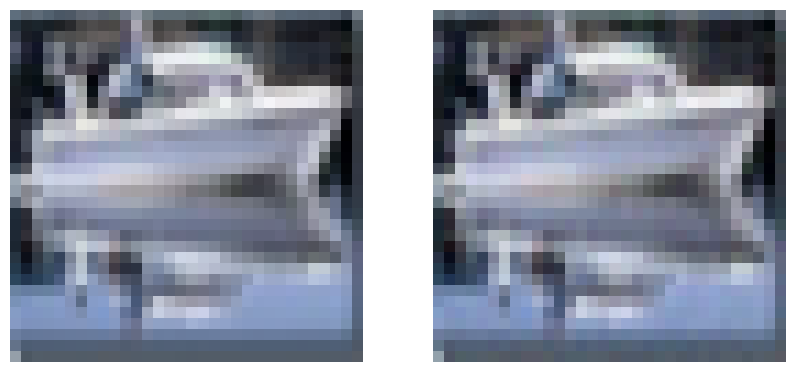

In [24]:
for step, (images, labels) in enumerate(train_loader):
      # 0. Prepare the data. Move the data to the device (CPU/GPU).
      images, labels = images.to(device), labels.to(device)
      # 1. Clear previous gradients.
      optimizer.zero_grad()
      # Take a step away from the correct label rather than away from the predicted label.
      perturbed_input = fgsm(model_normal_augmented, images, labels, 0.01, False)

      image_np_original = images[0].permute(1, 2, 0).cpu().detach().numpy()
      image_np_perturbed = perturbed_input[0].permute(1, 2, 0).cpu().detach().numpy()

      fig, axes = plt.subplots(1, 2, figsize=(10, 5))
      axes[0].imshow(image_np_original)
      axes[0].axis('off')  # Hide axes

      axes[1].imshow(image_np_perturbed)
      axes[1].axis('off')  # Hide axes

      plt.show()

      break

We can see that data augmentation improved the accuracy of the model significantly, up to 70% on my best run. However, the accuracy on the adversarial set only increased slightly, up to 31%.

(I didn't use different hyperparameters, I just reran the model with different random initializations.)

This model uses many linear layers, which may make it prone to overfitting. I also tried using a fully convolutional network but was unable to get sufficient accuracy on the validation set to justify analyzing the model (my max accuracy was only 55%). For reference, I have included the model that I was using below.

In [ ]:
class FullyConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.nn = nn.Sequential(
      # use 5 convolution layers and 1 linear layer
      nn.Conv2d(3, 16, 3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(16, 32, 3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(32, 64, 3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(64, 128, 3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(128, 128, 3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Flatten(),

      nn.Linear(128, 10),
      nn.ReLU(),
    )

  def forward(self, x):
    return self.nn.forward(x)

As a final comparison, let's see if a pretrained ResNet is also vulnerable to this attack:

In [ ]:
class ResNetModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.nn = nn.Sequential(
        resnet18(pretrained=True),
        nn.Linear(1000, 10),
    )

  def forward(self, x):
    return self.nn.forward(x)

In [ ]:
# setup and train the neural network
model_resnet = ResNetModel().to(device)

lr = 1e-3
gamma = 0.9
num_epoch = 10

optimizer = torch.optim.Adam(model_resnet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

train(model_resnet, num_epoch, optimizer, scheduler)
evaluate_adversarial_attack(model_resnet, fgsm, eps=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Step 0, Loss 3.4287
Epoch 0, Step 700, Loss 0.7794


100%|██████████| 157/157 [00:01<00:00, 82.47it/s]


Epoch 0, Valid Accuracy 71.96%


100%|██████████| 782/782 [00:11<00:00, 66.26it/s]


Epoch 0, Train Accuracy 75.23%
Epoch 1, Step 0, Loss 0.8054
Epoch 1, Step 700, Loss 0.5747


100%|██████████| 157/157 [00:01<00:00, 82.53it/s]


Epoch 1, Valid Accuracy 75.28%


100%|██████████| 782/782 [00:12<00:00, 63.05it/s]


Epoch 1, Train Accuracy 81.02%
Epoch 2, Step 0, Loss 0.5489
Epoch 2, Step 700, Loss 0.4944


100%|██████████| 157/157 [00:02<00:00, 76.07it/s]


Epoch 2, Valid Accuracy 79.82%


100%|██████████| 782/782 [00:11<00:00, 66.23it/s]


Epoch 2, Train Accuracy 87.82%
Epoch 3, Step 0, Loss 0.3944
Epoch 3, Step 700, Loss 0.2531


100%|██████████| 157/157 [00:02<00:00, 61.58it/s]


Epoch 3, Valid Accuracy 76.39%


100%|██████████| 782/782 [00:11<00:00, 68.58it/s]


Epoch 3, Train Accuracy 85.32%
Epoch 4, Step 0, Loss 0.3545
Epoch 4, Step 700, Loss 0.2827


100%|██████████| 157/157 [00:02<00:00, 63.64it/s]


Epoch 4, Valid Accuracy 80.75%


100%|██████████| 782/782 [00:11<00:00, 68.25it/s]


Epoch 4, Train Accuracy 93.48%
Epoch 5, Step 0, Loss 0.3886
Epoch 5, Step 700, Loss 0.3330


100%|██████████| 157/157 [00:01<00:00, 81.99it/s]


Epoch 5, Valid Accuracy 81.31%


100%|██████████| 782/782 [00:11<00:00, 67.37it/s]


Epoch 5, Train Accuracy 95.86%
Epoch 6, Step 0, Loss 0.0958
Epoch 6, Step 700, Loss 0.2253


100%|██████████| 157/157 [00:01<00:00, 81.85it/s]


Epoch 6, Valid Accuracy 79.57%


100%|██████████| 782/782 [00:11<00:00, 67.44it/s]


Epoch 6, Train Accuracy 96.03%
Epoch 7, Step 0, Loss 0.0373
Epoch 7, Step 700, Loss 0.1180


100%|██████████| 157/157 [00:01<00:00, 78.70it/s]


Epoch 7, Valid Accuracy 79.36%


100%|██████████| 782/782 [00:11<00:00, 66.92it/s]


Epoch 7, Train Accuracy 95.82%
Epoch 8, Step 0, Loss 0.0612
Epoch 8, Step 700, Loss 0.0711


100%|██████████| 157/157 [00:01<00:00, 82.21it/s]


Epoch 8, Valid Accuracy 81.77%


100%|██████████| 782/782 [00:11<00:00, 66.89it/s]


Epoch 8, Train Accuracy 98.55%
Epoch 9, Step 0, Loss 0.0345
Epoch 9, Step 700, Loss 0.0418


100%|██████████| 157/157 [00:01<00:00, 82.84it/s]


Epoch 9, Valid Accuracy 81.85%


100%|██████████| 782/782 [00:11<00:00, 66.61it/s]


Epoch 9, Train Accuracy 99.27%
Adversarial robustness:  0.32264


I also tried an augmented ResNet, but the performance in terms of accuracy or robustness did not change, while the training cost went up by 3x.

As we can see, even ResNet is vulnerable to the FGSM attack. We will now look at a defense that will make the model more resilient, without changing the underlying architecture.

In order to accomplish this, we can't simply add the adversarial set to the list of transforms. As we have already seen, adding transforms such as crop or color jitter does not increase the model robustness. Instead, we will update the loss function. Instead of computing L(x), where x is the training example, we will compute L(x'), where x' is the worst adversarial example we can find in the $L_\infty$ ball centered at the original image.

(I have already included this code in the training function above, feel free to refer back to it to view the code.)

Let's now run this adversarial training on our simple CNN and see how the results compare.

In [ ]:
model_normal_resilient = CNN().to(device)
lr = 1e-3
gamma = 0.9
num_epoch = 10

optimizer = torch.optim.Adam(model_normal_resilient.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

train(model_normal_resilient, num_epoch, optimizer, scheduler, augment=True, attack_fn=fgsm, eps=0.01)
evaluate_adversarial_attack(model_normal_resilient, fgsm, eps=0.01)

Epoch 0, Step 0, Loss 2.3102
Epoch 0, Step 700, Loss 2.0449


100%|██████████| 157/157 [00:01<00:00, 109.44it/s]


Epoch 0, Valid Accuracy 42.65%


100%|██████████| 782/782 [00:07<00:00, 103.50it/s]


Epoch 0, Train Accuracy 42.78%
Epoch 1, Step 0, Loss 1.9153
Epoch 1, Step 700, Loss 1.8754


100%|██████████| 157/157 [00:01<00:00, 109.03it/s]


Epoch 1, Valid Accuracy 49.58%


100%|██████████| 782/782 [00:08<00:00, 91.87it/s]


Epoch 1, Train Accuracy 50.11%
Epoch 2, Step 0, Loss 1.8666
Epoch 2, Step 700, Loss 1.5932


100%|██████████| 157/157 [00:01<00:00, 81.25it/s]


Epoch 2, Valid Accuracy 51.88%


100%|██████████| 782/782 [00:07<00:00, 108.04it/s]


Epoch 2, Train Accuracy 52.65%
Epoch 3, Step 0, Loss 1.8251
Epoch 3, Step 700, Loss 1.8373


100%|██████████| 157/157 [00:01<00:00, 107.39it/s]


Epoch 3, Valid Accuracy 54.23%


100%|██████████| 782/782 [00:08<00:00, 97.32it/s]


Epoch 3, Train Accuracy 55.17%
Epoch 4, Step 0, Loss 1.7776
Epoch 4, Step 700, Loss 1.8425


100%|██████████| 157/157 [00:01<00:00, 109.86it/s]


Epoch 4, Valid Accuracy 53.92%


100%|██████████| 782/782 [00:08<00:00, 94.64it/s] 


Epoch 4, Train Accuracy 54.93%
Epoch 5, Step 0, Loss 1.9446
Epoch 5, Step 700, Loss 1.9539


100%|██████████| 157/157 [00:02<00:00, 78.23it/s]


Epoch 5, Valid Accuracy 57.29%


100%|██████████| 782/782 [00:07<00:00, 105.11it/s]


Epoch 5, Train Accuracy 58.22%
Epoch 6, Step 0, Loss 1.5566
Epoch 6, Step 700, Loss 1.8571


100%|██████████| 157/157 [00:01<00:00, 111.17it/s]


Epoch 6, Valid Accuracy 57.69%


100%|██████████| 782/782 [00:08<00:00, 97.45it/s]


Epoch 6, Train Accuracy 59.20%
Epoch 7, Step 0, Loss 1.4711
Epoch 7, Step 700, Loss 1.6363


100%|██████████| 157/157 [00:01<00:00, 100.57it/s]


Epoch 7, Valid Accuracy 59.43%


100%|██████████| 782/782 [00:08<00:00, 95.62it/s] 


Epoch 7, Train Accuracy 60.55%
Epoch 8, Step 0, Loss 1.7192
Epoch 8, Step 700, Loss 1.4698


100%|██████████| 157/157 [00:01<00:00, 97.01it/s] 


Epoch 8, Valid Accuracy 59.40%


100%|██████████| 782/782 [00:07<00:00, 103.27it/s]


Epoch 8, Train Accuracy 60.67%
Epoch 9, Step 0, Loss 1.6812
Epoch 9, Step 700, Loss 1.6688


100%|██████████| 157/157 [00:01<00:00, 108.28it/s]


Epoch 9, Valid Accuracy 60.13%


100%|██████████| 782/782 [00:08<00:00, 93.61it/s] 


Epoch 9, Train Accuracy 61.66%
Adversarial robustness:  0.46318


Using the adversarial training, we see an accuracy of 60%, which is somewhat lower than the previously observed 70%. We also notice that the robustness jumps from 30% to 46%, which is a large improvement.

Let's run the same adversarial training method on our ResNet to see if we get similar results.

In [ ]:
# setup and train the neural network
model_resnet_resilient = ResNetModel().to(device)

lr = 1e-3
gamma = 0.9
num_epoch = 10

optimizer = torch.optim.Adam(model_resnet_resilient.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

train(model_resnet_resilient, num_epoch, optimizer, scheduler, attack_fn=fgsm, eps=0.01)
evaluate_adversarial_attack(model_resnet_resilient, fgsm, eps=0.01)

Epoch 0, Step 0, Loss 3.4566
Epoch 0, Step 700, Loss 1.4503


100%|██████████| 157/157 [00:02<00:00, 66.12it/s]


Epoch 0, Valid Accuracy 63.47%


100%|██████████| 782/782 [00:11<00:00, 66.79it/s]


Epoch 0, Train Accuracy 64.46%
Epoch 1, Step 0, Loss 1.3081
Epoch 1, Step 700, Loss 1.3018


100%|██████████| 157/157 [00:01<00:00, 81.07it/s]


Epoch 1, Valid Accuracy 63.29%


100%|██████████| 782/782 [00:11<00:00, 65.95it/s]


Epoch 1, Train Accuracy 65.30%
Epoch 2, Step 0, Loss 1.3194
Epoch 2, Step 700, Loss 1.2622


100%|██████████| 157/157 [00:01<00:00, 81.86it/s]


Epoch 2, Valid Accuracy 55.69%


100%|██████████| 782/782 [00:11<00:00, 66.79it/s]


Epoch 2, Train Accuracy 59.26%
Epoch 3, Step 0, Loss 1.1126
Epoch 3, Step 700, Loss 1.1906


100%|██████████| 157/157 [00:01<00:00, 82.32it/s]


Epoch 3, Valid Accuracy 68.80%


100%|██████████| 782/782 [00:11<00:00, 67.30it/s]


Epoch 3, Train Accuracy 71.80%
Epoch 4, Step 0, Loss 1.0534
Epoch 4, Step 700, Loss 1.3386


100%|██████████| 157/157 [00:01<00:00, 78.62it/s]


Epoch 4, Valid Accuracy 67.68%


100%|██████████| 782/782 [00:11<00:00, 68.10it/s]


Epoch 4, Train Accuracy 71.51%
Epoch 5, Step 0, Loss 1.1309
Epoch 5, Step 700, Loss 1.0912


100%|██████████| 157/157 [00:02<00:00, 59.55it/s]


Epoch 5, Valid Accuracy 64.97%


100%|██████████| 782/782 [00:11<00:00, 67.69it/s]


Epoch 5, Train Accuracy 68.20%
Epoch 6, Step 0, Loss 1.1070
Epoch 6, Step 700, Loss 1.0707


100%|██████████| 157/157 [00:02<00:00, 65.01it/s]


Epoch 6, Valid Accuracy 68.47%


100%|██████████| 782/782 [00:11<00:00, 67.68it/s]


Epoch 6, Train Accuracy 73.27%
Epoch 7, Step 0, Loss 1.2581
Epoch 7, Step 700, Loss 1.2523


100%|██████████| 157/157 [00:01<00:00, 79.51it/s]


Epoch 7, Valid Accuracy 66.40%


100%|██████████| 782/782 [00:11<00:00, 66.22it/s]


Epoch 7, Train Accuracy 70.92%
Epoch 8, Step 0, Loss 1.2568
Epoch 8, Step 700, Loss 1.0830


100%|██████████| 157/157 [00:01<00:00, 81.53it/s]


Epoch 8, Valid Accuracy 63.62%


100%|██████████| 782/782 [00:11<00:00, 66.75it/s]


Epoch 8, Train Accuracy 67.72%
Epoch 9, Step 0, Loss 1.2566
Epoch 9, Step 700, Loss 1.1183


100%|██████████| 157/157 [00:01<00:00, 80.96it/s]


Epoch 9, Valid Accuracy 66.52%


100%|██████████| 782/782 [00:12<00:00, 65.01it/s]


Epoch 9, Train Accuracy 71.08%
Adversarial robustness:  0.50418


As we can see, getting the ResNet to train using adversarial training leads to lower results in terms of accuracy, as the entire network itself needs to be significantly changed to be more robust.

The results we have seen so far also have the following two issues:
- After using adversarial training, we are only getting about 50% robustness, which is very low compared to our desired value.

To combatthis issue, we will use adversarial training with a stronger attack known as PGD. This attack performs FGSM iteratively, while clipping the result at eash iteration to stay within the $L_\infty$ ball of the original input. Using this, we should be able to get more robust models, and better adversarial examples on models without proper defenses.

In [ ]:
# Ensure we remain within the L-inf ball of the original image.
# This is not needed for FGSM as it only takes a single step, and the magnitude of the step is at most epsilon.
def clip(x, x_baseline, eps):
    x = torch.minimum(x, x_baseline + eps)
    x = torch.maximum(x, x_baseline - eps)
    return x

def pgd_untargeted(model, x, labels, eps, targeted=False, k=5):
    # No targeted version was implemented, since it is not needed to make the model robust
    fgsm_in = x.clone().detach()
    fgsm_in.requires_grad_()
    for i in range(k):
      # Apply FGSM over k iterations to see if we can get a more adversarial image
      perturb = fgsm(model, fgsm_in, labels, eps, False)
      fgsm_in = clip(perturb, x, eps)
    return fgsm_in

In [ ]:
evaluate_adversarial_attack(model_normal_augmented, pgd_untargeted, eps=0.01)
evaluate_adversarial_attack(model_resnet, pgd_untargeted, eps=0.01)

Adversarial robustness:  0.26618
Adversarial robustness:  0.15744


As we can see, the robustness does down when we attack the model using PGD. This effect is especially noticeable for ResNet.
As a final test, let's see if the adversarially trained models generalize and are resilient against the PGD attack on the same $ϵ$.

In [ ]:
evaluate_adversarial_attack(model_normal_resilient, pgd_untargeted, eps=0.01)
evaluate_adversarial_attack(model_resnet_resilient, pgd_untargeted, eps=0.01)

Adversarial robustness:  0.44676
Adversarial robustness:  0.48548


In this specific case, robustness remains quite high even against the PGD attack. However, this is not true in the general case.

In practice, it has been shown that networks that are adversarially trained against PGD are robust against most common attacks, while networks trained on FGSM are not. However, even PGD networks are not provably robust.

We have also not shown that our training method is robust on real data, but only on the training set. In practice, results on adversarial robustness tend to generalize, although this is not always the case.